![headers_fraud-prev](headers_fraud-prev.jpg)


# Credit Card Fraud

This dataset consists of credit card transactions in the western United States. It includes information about each transaction including customer details, the merchant and category of purchase, and whether or not the transaction was a fraud.

Note: You can access the data via the File menu or in the Context Panel at the top right of the screen next to Report, under Files. The data dictionary and filenames can be found at the bottom of this workbook.

[Source: Kaggle](https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv) The data was partially cleaned and adapted by DataCamp.


## Questions Answered in this dataset

1. 🗺️ **Exploration**: What types of purchases are most likely to be instances of fraud? 
2. 📊 **Visualization**: Use a geospatial plot to visualize the fraud rates across different states.
3. 🔎 **Analyzation**: Are older customers significantly more likely to be victims of credit card fraud?

### 🔍 **Scenario: Accurately Predict Instances of Credit Card Fraud**

**Background:** A new credit card company has just entered the market in the western United States. The company is promoting itself as one of the safest credit cards to use. They have hired us as their data scientist in charge of identifying instances of fraud. The executive who hired us has have provided us with data on credit card transactions, including whether or not each transaction was fraudulent.

**Objective:** The executive wants to know how accurately we can predict fraud using this data. She has stressed that the model should err on the side of caution: it is not a big problem to flag transactions as fraudulent when they aren't just to be safe. In your report, we will need to describe how well the model functions and how it adheres to these criteria.

We will need to prepare a report that is accessible to a broad audience. It will need to outline your motivation, analysis steps, findings, and conclusions.

You can query the pre-loaded CSV file using SQL directly. Here’s a **sample query**, followed by some sample Python code and outputs:

## Data Dictionary

| transdatetrans_time | Transaction DateTime                        |
|---------------------|---------------------------------------------|
| merchant            | Merchant Name                               |
| category            | Category of Merchant                        |
| amt                 | Amount of Transaction                       |
| city                | City of Credit Card Holder                  |
| state               | State of Credit Card Holder                 |
| lat                 | Latitude Location of Purchase               |
| long                | Longitude Location of Purchase              |
| city_pop            | Credit Card Holder's City Population        |
| job                 | Job of Credit Card Holder                   |
| dob                 | Date of Birth of Credit Card Holder         |
| trans_num           | Transaction Number                          |
| merch_lat           | Latitude Location of Merchant               |
| merch_long          | Longitude Location of Merchant              |
| is_fraud            | Whether Transaction is Fraud (1) or Not (0) |

In [79]:
# Import Important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score


In [80]:
# Load Data
df = pd.read_csv('credit_card_fraud.csv') 
df.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,"Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0
1,2019-01-01 00:00:51,Lind-Buckridge,entertainment,220.11,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0
2,2019-01-01 00:07:27,Kiehn Inc,grocery_pos,96.29,Grenada,CA,41.6125,-122.5258,589,Systems analyst,1945-12-21,413636e759663f264aae1819a4d4f231,41.657520,-122.230347,0
3,2019-01-01 00:09:03,Beier-Hyatt,shopping_pos,7.77,High Rolls Mountain Park,NM,32.9396,-105.8189,899,Naval architect,1967-08-30,8a6293af5ed278dea14448ded2685fea,32.863258,-106.520205,0
4,2019-01-01 00:21:32,Bruen-Yost,misc_pos,6.85,Freedom,WY,43.0172,-111.0292,471,"Education officer, museum",1967-08-02,f3c43d336e92a44fc2fb67058d5949e3,43.753735,-111.454923,0


# **Data Understanding & Quality Checks**

In [81]:
# Column info (dtype + unique values)
colinfo = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "nunique": df.nunique()
}).sort_index()
display(colinfo)

,dtype,nunique
amt,float64,32112
category,object,14
city,object,176
city_pop,int64,174
dob,object,187
is_fraud,int64,2
job,object,163
lat,float64,183
long,float64,183
merch_lat,float64,335608


In [82]:
# Nulls snapshot
missing = (df.isna().sum().sort_values(ascending=False) / len(df) * 100).round(2)
print("\n% Missing by column (top 10):")
print(missing.head(10))


% Missing by column (top 10):
trans_date_trans_time    0.0
merchant                 0.0
category                 0.0
amt                      0.0
city                     0.0
state                    0.0
lat                      0.0
long                     0.0
city_pop                 0.0
job                      0.0
dtype: float64


In [83]:
# Overview & fraud rate
print("== Overview ==")
n_rows, n_cols = df.shape
fraud_rate = df["is_fraud"].mean() * 100
print(f"Rows: {n_rows:,}  |  Cols: {n_cols}")
print(f"Fraud rate: {fraud_rate:.3f}%")
print()

== Overview ==
Rows: 339,607  |  Cols: 15
Fraud rate: 0.525%



In [84]:
# Missingness summary
def summarize_missingness(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().sum().to_frame("missing_count")
    miss["missing_pct"] = (miss["missing_count"] / len(df) * 100).round(3)
    miss = miss.sort_values("missing_count", ascending=False)
    return miss

print("\n== Missingness Summary ==")
missing = summarize_missingness(df)
display(missing)


== Missingness Summary ==


,missing_count,missing_pct
trans_date_trans_time,0,0.0
merchant,0,0.0
category,0,0.0
amt,0,0.0
city,0,0.0
state,0,0.0
lat,0,0.0
long,0,0.0
city_pop,0,0.0
job,0,0.0


In [85]:
# Numeric summary (core numeric columns)
num_cols = ["amt","city_pop","lat","long","merch_lat","merch_long"]
num_cols = [c for c in num_cols if c in df.columns]  # guard
print("\n== Numeric Summary ==")
display(df[num_cols].describe().T)


== Numeric Summary ==


,count,mean,std,min,25%,50%,75%,max
amt,339607.0,70.577984,161.675242,1.000000,9.600000,46.460000,83.350000,2.894890e+04
city_pop,339607.0,107140.865515,293029.887292,46.000000,471.000000,1645.000000,35439.000000,2.383912e+06
lat,339607.0,39.718991,5.094961,20.027100,36.715400,39.617100,41.710000,6.669330e+01
long,339607.0,-110.622605,12.651370,-165.672300,-120.093600,-111.098500,-100.621500,-8.962870e+01
merch_lat,339607.0,39.718853,5.130894,19.027422,36.817194,39.586209,42.193072,6.751027e+01
merch_long,339607.0,-110.622383,12.663998,-166.671575,-119.823755,-111.036443,-100.353096,-8.862920e+01


In [86]:
# Top cardinalities (sanity look at distributions)
print("\n== Top Categories / States / Merchants (by count) ==")
if "category" in df.columns:
    display(df["category"].value_counts().head(15).to_frame("count"))
if "state" in df.columns:
    display(df["state"].value_counts().head(15).to_frame("count"))
if "merchant" in df.columns:
    display(df["merchant"].value_counts().head(15).to_frame("count"))



== Top Categories / States / Merchants (by count) ==


,count
category,
gas_transport,35089
grocery_pos,32732
home,32516
shopping_pos,30329
kids_pets,29704
shopping_net,26379
personal_care,24406
entertainment,24222
food_dining,23038


,count
state,
CA,80495
MO,54904
NE,34425
WY,27776
WA,27040
OR,26408
NM,23427
CO,19766
AZ,15362


,count
merchant,
Kilback LLC,1149
Cormier LLC,985
Schumm PLC,931
Kuhn LLC,896
Dickinson Lt,891
Boyer PLC,869
"Christiansen, Goyette and Schamberge",750
Erdman-Kertzmann,746
Bartoletti-Wunsch,741


# **Exploratory Data Analysis and Insights**

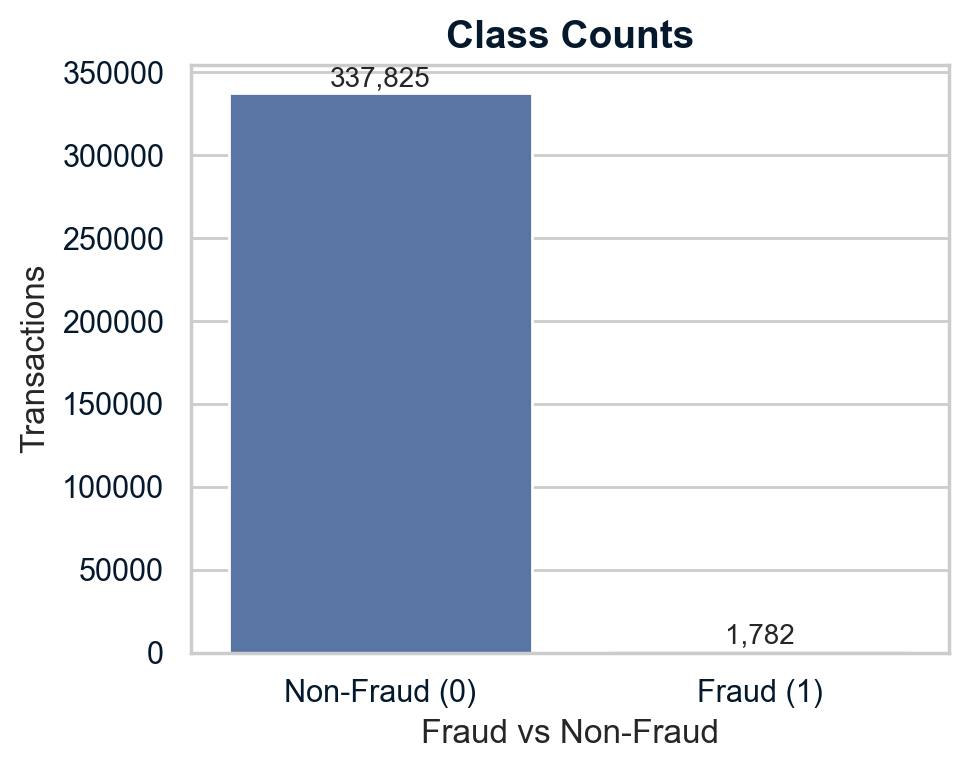

In [87]:
# ---------- Class imbalance ----------
counts = df["is_fraud"].value_counts().sort_index()
labels = ["Non-Fraud (0)", "Fraud (1)"]

sns.set_theme(style="whitegrid", palette="muted")  # Set consistent theme & palette

plt.figure(figsize=(5, 4))
ax = sns.barplot(x=labels, y=counts.values, palette=["#4C72B0", "#DD8452"])

# Titles & labels
ax.set_title("Class Counts", fontsize=14, fontweight="bold")
ax.set_ylabel("Transactions", fontsize=12)
ax.set_xlabel("Fraud vs Non-Fraud") 

# Add value labels on bars
for i, val in enumerate(counts.values):
    ax.text(i, val + max(counts.values)*0.01, f"{val:,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [88]:
fraud_counts = df["is_fraud"].value_counts()
print(fraud_counts)

fraud_percentage = df["is_fraud"].value_counts(normalize=True) * 100
print(fraud_percentage)


is_fraud
0    337825
1      1782
Name: count, dtype: int64
is_fraud
0    99.475276
1     0.524724
Name: proportion, dtype: float64


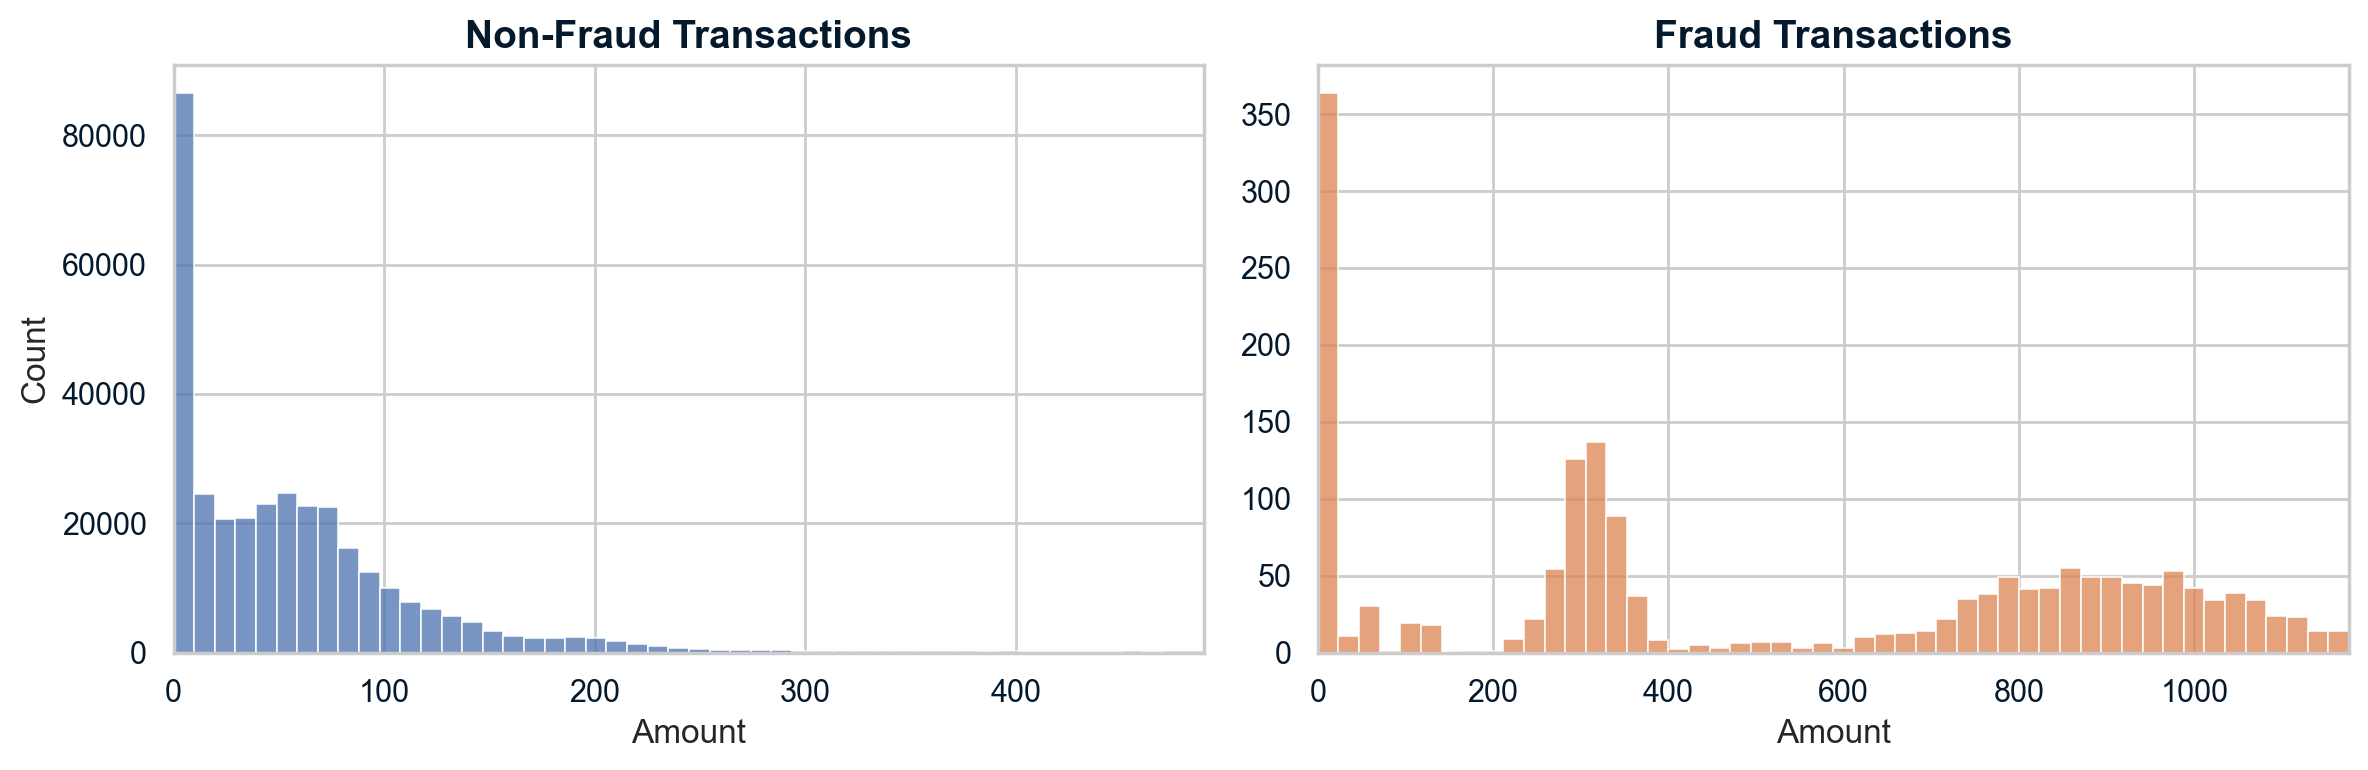

In [89]:
# ---------- Amount analysis (Non Fraud vs Fraud) ----------
sns.set_theme(style="whitegrid", palette="muted")

nonfraud = df[df["is_fraud"] == 0].copy()
fraud    = df[df["is_fraud"] == 1].copy()

# Quantile-based zoom to avoid long tails dominating the axis
q_nf = nonfraud["amt"].quantile(0.99)
q_f  = fraud["amt"].quantile(0.99)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# Non-Fraud
sns.histplot(
    data=nonfraud, x="amt", bins=50,
    binrange=(0, q_nf), color="#4C72B0", edgecolor=None, ax=axes[0]
)
axes[0].set_title("Non-Fraud Transactions", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Amount"); axes[0].set_ylabel("Count")
axes[0].set_xlim(0, q_nf)

# Fraud
sns.histplot(
    data=fraud, x="amt", bins=50,
    binrange=(0, q_f), color="#DD8452", edgecolor=None, ax=axes[1]
)
axes[1].set_title("Fraud Transactions", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Amount"); axes[1].set_ylabel("")
axes[1].set_xlim(0, q_f)

plt.tight_layout()
plt.show()


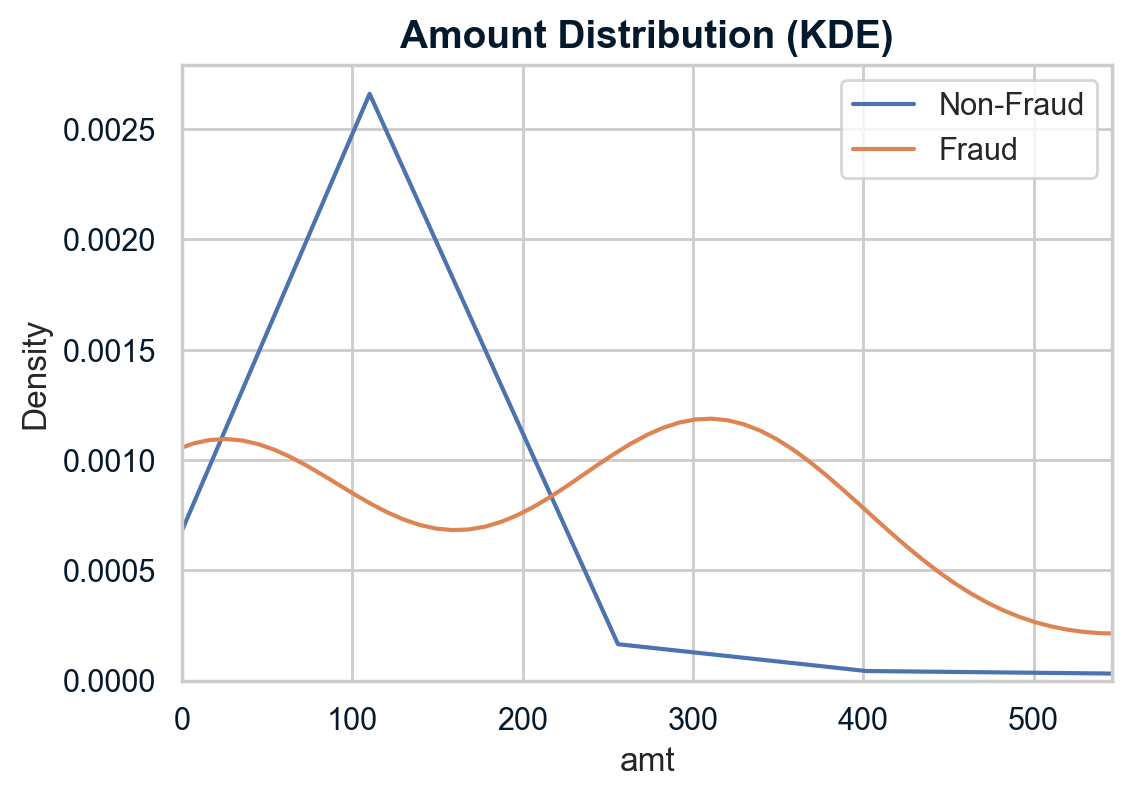

In [90]:
# ------Probability Densities-------
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df[df["is_fraud"] == 0], x="amt", color="#4C72B0", label="Non-Fraud")
sns.kdeplot(data=df[df["is_fraud"] == 1], x="amt", color="#DD8452", label="Fraud")
plt.xlim(0, df["amt"].quantile(0.99))
plt.title("Amount Distribution (KDE)", fontsize=14, fontweight="bold")
plt.legend()
plt.show()


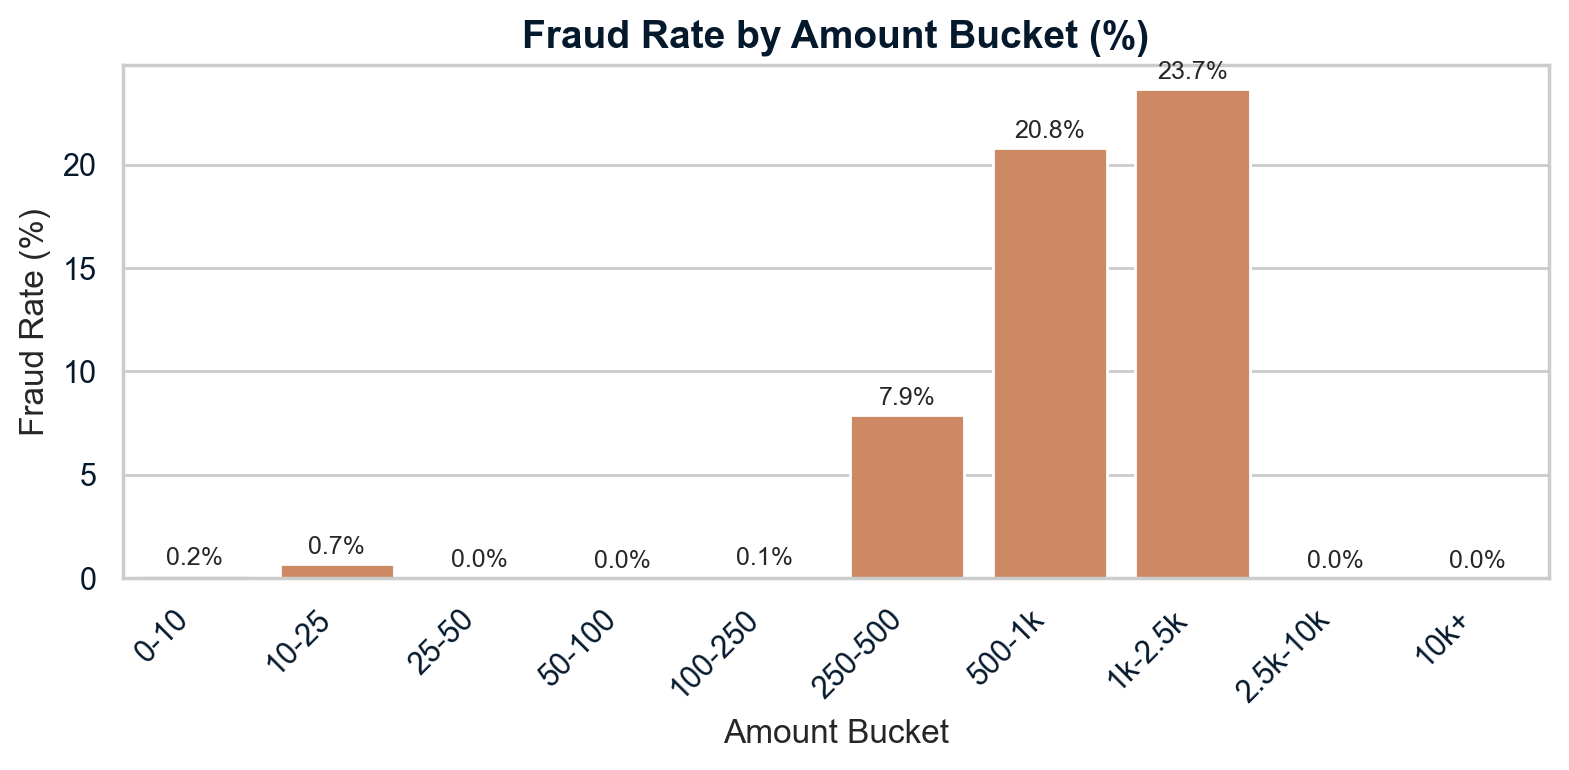

In [91]:
# ---------- Amount buckets + fraud rate per bucket ----------
amt_bins = [0, 10, 25, 50, 100, 250, 500, 1000, 2500, 10000, np.inf]
amt_labels = ["0-10","10-25","25-50","50-100","100-250","250-500","500-1k","1k-2.5k","2.5k-10k","10k+"]

df["amt_bucket"] = pd.cut(
    df["amt"],
    bins=amt_bins,
    labels=amt_labels,
    right=False,
    include_lowest=True
)

fraud_by_amt_bucket = (
    df.groupby("amt_bucket")["is_fraud"]
      .mean()
      .mul(100)
      .reindex(amt_labels)
      .reset_index(name="fraud_rate")
)

sns.set_theme(style="whitegrid", palette="muted")

plt.figure(figsize=(8, 4))
ax = sns.barplot(
    data=fraud_by_amt_bucket,
    x="amt_bucket", y="fraud_rate",
    color="#DD8452"  # Fraud color
)

# Titles & labels
ax.set_title("Fraud Rate by Amount Bucket (%)", fontsize=14, fontweight="bold")
ax.set_xlabel("Amount Bucket", fontsize=12)
ax.set_ylabel("Fraud Rate (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Value labels on top
for i, v in enumerate(fraud_by_amt_bucket["fraud_rate"]):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


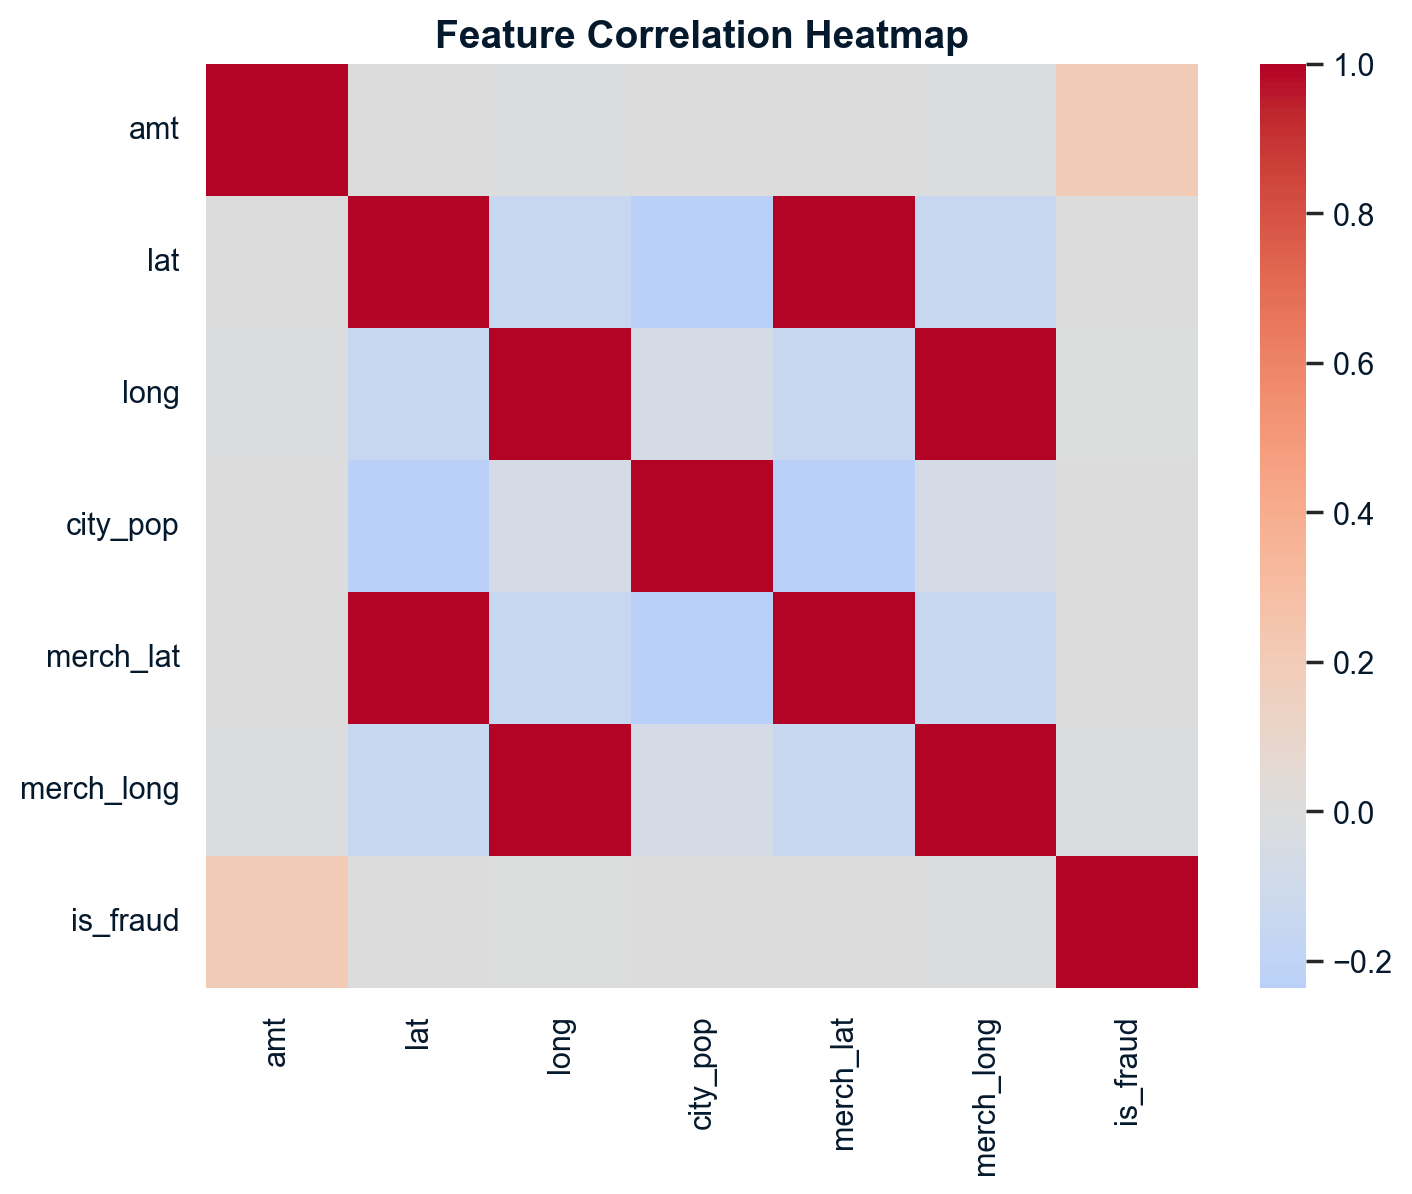

In [92]:
# ------Feature Relationships--------
plt.figure(figsize=(8, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight="bold")
plt.show()


In [93]:
# ---------- Category risk ----------
cat_stats = (
    df.groupby("category")
      .agg(txn_count=("category","size"),
           fraud_rate=("is_fraud","mean"))
      .sort_values("fraud_rate", ascending=False)
)
cat_stats["fraud_rate"] = (cat_stats["fraud_rate"] * 100).round(2)

# Focus on categories with enough data (e.g., >= 500 txns). Adjust threshold if dataset is smaller.
cat_filtered = cat_stats[cat_stats["txn_count"] >= 500].copy()
print("\nTop categories by fraud rate (min 500 txns):")
display(cat_filtered.head(15))




Top categories by fraud rate (min 500 txns):


,txn_count,fraud_rate
category,,
shopping_net,26379,1.44
grocery_pos,32732,1.32
misc_net,16898,1.28
shopping_pos,30329,0.62
gas_transport,35089,0.44
travel,10322,0.32
misc_pos,20024,0.31
grocery_net,11355,0.24
entertainment,24222,0.23


In [94]:
# ---------- Geography ----------
state_stats = (
    df.groupby("state")["is_fraud"]
      .agg(txn_count="count", fraud_rate="mean")
      .sort_values("fraud_rate", ascending=False)
)
state_stats["fraud_rate"] = (state_stats["fraud_rate"] * 100).round(2)

# Show states with at least 500 transactions (adjust threshold as needed)
state_filtered = state_stats[state_stats["txn_count"] >= 500].copy()
print("\nStates by fraud rate (min 500 txns):")
display(state_filtered.head(15))




States by fraud rate (min 500 txns):


,txn_count,fraud_rate
state,,
AK,2963,1.69
OR,26408,0.75
NE,34425,0.63
CO,19766,0.58
NM,23427,0.52
CA,80495,0.50
MO,54904,0.48
WA,27040,0.47
HI,3649,0.44


In [95]:
# ---------- Merchants ----------
# Merchant fraud rate with a minimum support to avoid tiny-sample noise
merchant_stats = (
    df.groupby("merchant")["is_fraud"]
      .agg(txn_count="count", fraud_rate="mean")
      .sort_values("fraud_rate", ascending=False)
)
merchant_stats["fraud_rate"] = (merchant_stats["fraud_rate"] * 100).round(2)
merchant_filtered = merchant_stats[merchant_stats["txn_count"] >= 200].copy()
print("\nMerchants by fraud rate (min 200 txns):")
display(merchant_filtered.head(15))


Merchants by fraud rate (min 200 txns):


,txn_count,fraud_rate
merchant,,
"Romaguera, Cruickshank and Greenholt",521,3.45
Kerluke-Abshire,515,3.30
Kiehn-Emmerich,658,2.89
Terry-Huel,519,2.50
Kunze Inc,645,2.48
"Tillman, Fritsch and Schmitt",364,2.47
"Moore, Dibbert and Koepp",337,2.37
Welch Inc,342,2.34
Lebsack and Sons,358,2.23


In [96]:
# ----------Fraud Rate by State-------
state_map = state_stats.reset_index().rename(columns={"state":"location"})
fig = px.choropleth(
    state_map,
    locations="location", locationmode="USA-states",
    color="fraud_rate",
    scope="usa",
    color_continuous_scale="Reds",
    title="Fraud Rate by State (%)"
)
fig.show()


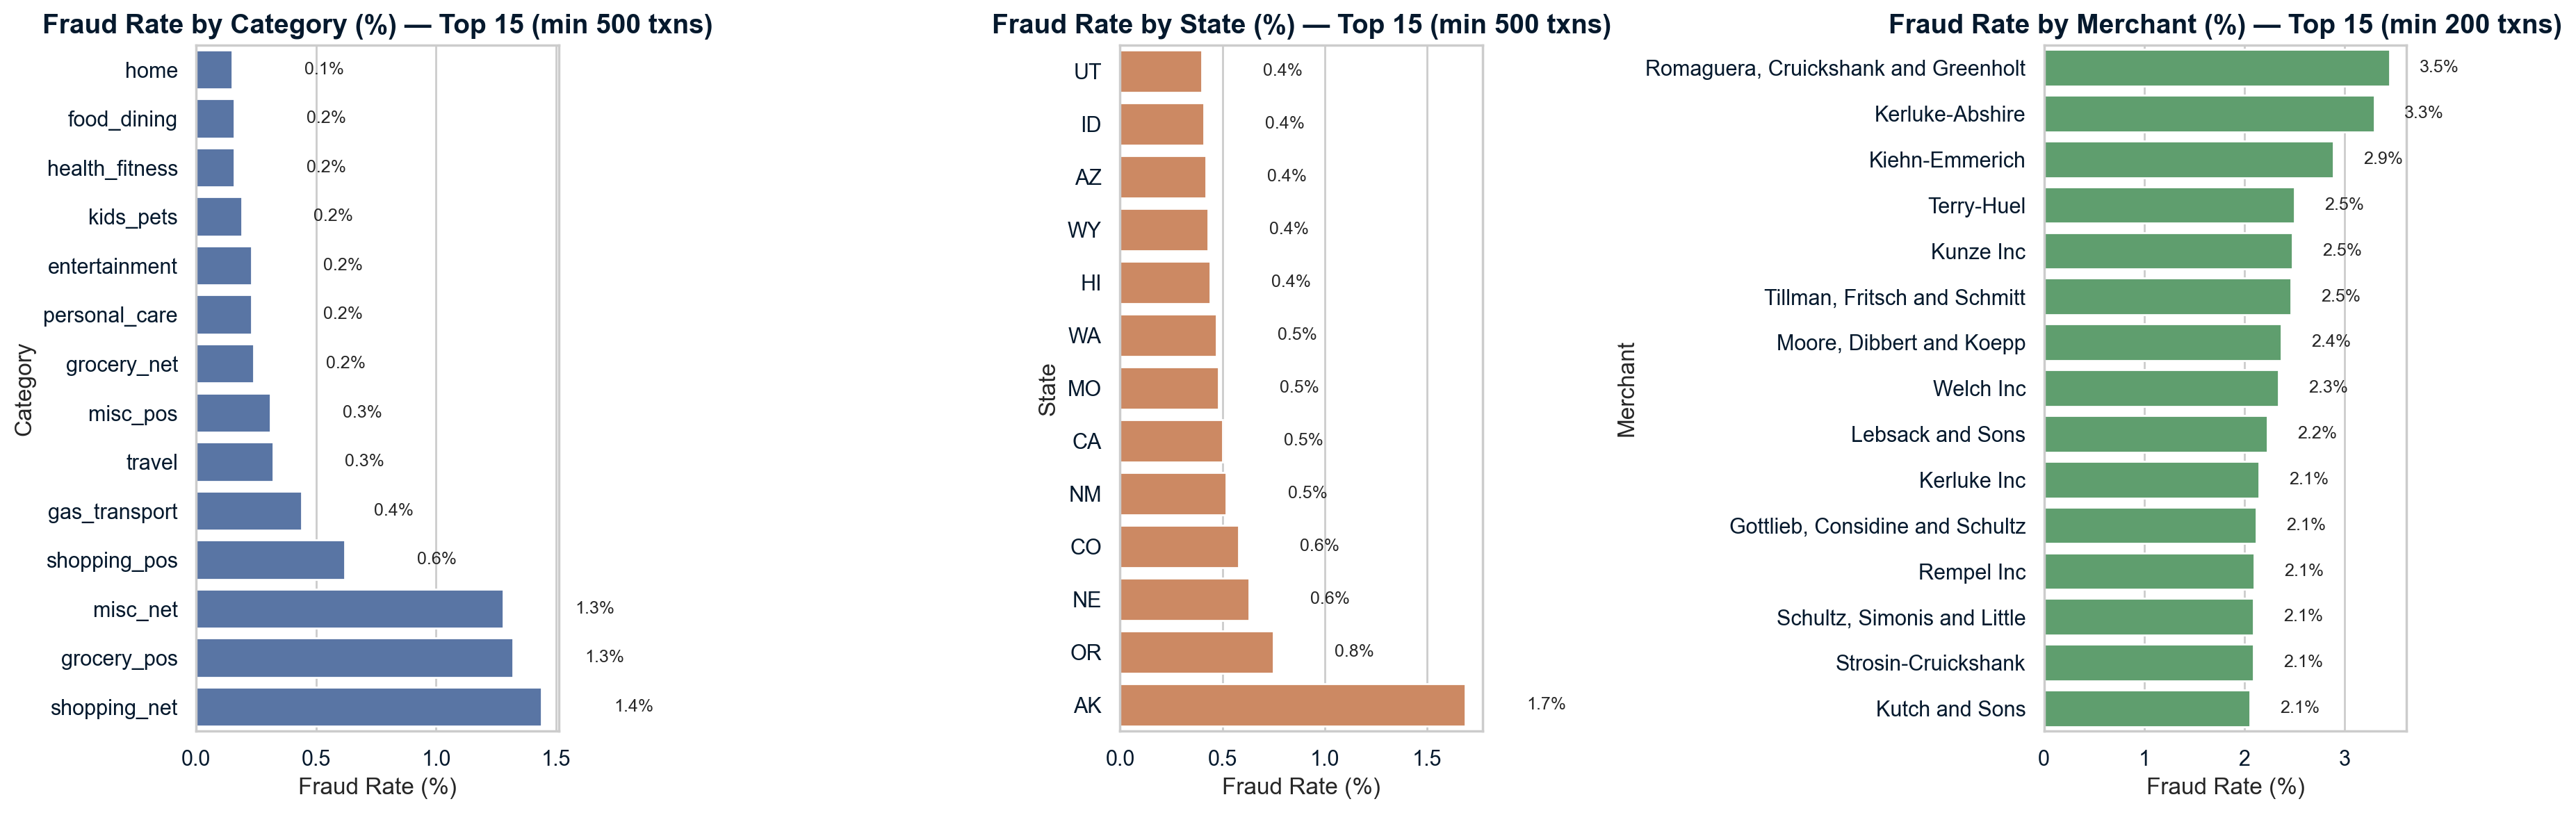

In [97]:
sns.set_theme(style="whitegrid", palette="muted")

# Prep top 15 for each view
top_cats = cat_filtered.head(15).sort_values("fraud_rate").reset_index()              # columns: index (category), fraud_rate
top_states = state_filtered.head(15).sort_values("fraud_rate").reset_index()          # columns: index (state), fraud_rate
top_merch = (
    merchant_filtered.sort_values("fraud_rate", ascending=False)
    .head(15)
    .reset_index()                                                                     # columns: merchant, txn_count, fraud_rate
)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- 1) Fraud Rate by Category (Blue) ---
sns.barplot(
    data=top_cats, x="fraud_rate", y=top_cats.columns[0],  # first col is the name from reset_index()
    color="#4C72B0", ax=axes[0]
)
axes[0].set_title("Fraud Rate by Category (%) — Top 15 (min 500 txns)", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Fraud Rate (%)")
axes[0].set_ylabel("Category")
for i, v in enumerate(top_cats["fraud_rate"]):
    axes[0].text(v + 0.3, i, f"{v:.1f}%", va="center", fontsize=9)

# --- 2) Fraud Rate by State (Orange) ---
sns.barplot(
    data=top_states, x="fraud_rate", y=top_states.columns[0],
    color="#DD8452", ax=axes[1]
)
axes[1].set_title("Fraud Rate by State (%) — Top 15 (min 500 txns)", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Fraud Rate (%)")
axes[1].set_ylabel("State")
for i, v in enumerate(top_states["fraud_rate"]):
    axes[1].text(v + 0.3, i, f"{v:.1f}%", va="center", fontsize=9)

# --- 3) Fraud Rate by Merchant (Green) ---
sns.barplot(
    data=top_merch, x="fraud_rate", y="merchant",
    color="#55A868", ax=axes[2]
)
axes[2].set_title("Fraud Rate by Merchant (%) — Top 15 (min 200 txns)", fontsize=14, fontweight="bold")
axes[2].set_xlabel("Fraud Rate (%)")
axes[2].set_ylabel("Merchant")
for i, v in enumerate(top_merch["fraud_rate"]):
    axes[2].text(v + 0.3, i, f"{v:.1f}%", va="center", fontsize=9)

plt.tight_layout()
plt.show()


In [98]:
# Parse the datetime columns
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"], errors="coerce")
df["dob"] = pd.to_datetime(df["dob"], errors="coerce")

# Calculate age in years at the time of transaction
df["age_years"] = round((df["trans_date_trans_time"] - df["dob"]).dt.days / 365)

# Create a column for transaction hour
df["trans_hour"] = df["trans_date_trans_time"].dt.hour

# Create a column for transaction day of the week
df["trans_dow"] = df["trans_date_trans_time"].dt.day_name()

# Preview the updated dataframe
print(df[["trans_date_trans_time", "dob", "age_years", "trans_hour", "trans_dow"]].head())


  trans_date_trans_time        dob  age_years  trans_hour trans_dow
0   2019-01-01 00:00:44 1978-06-21       41.0           0   Tuesday
1   2019-01-01 00:00:51 1962-01-19       57.0           0   Tuesday
2   2019-01-01 00:07:27 1945-12-21       73.0           0   Tuesday
3   2019-01-01 00:09:03 1967-08-30       51.0           0   Tuesday
4   2019-01-01 00:21:32 1967-08-02       51.0           0   Tuesday


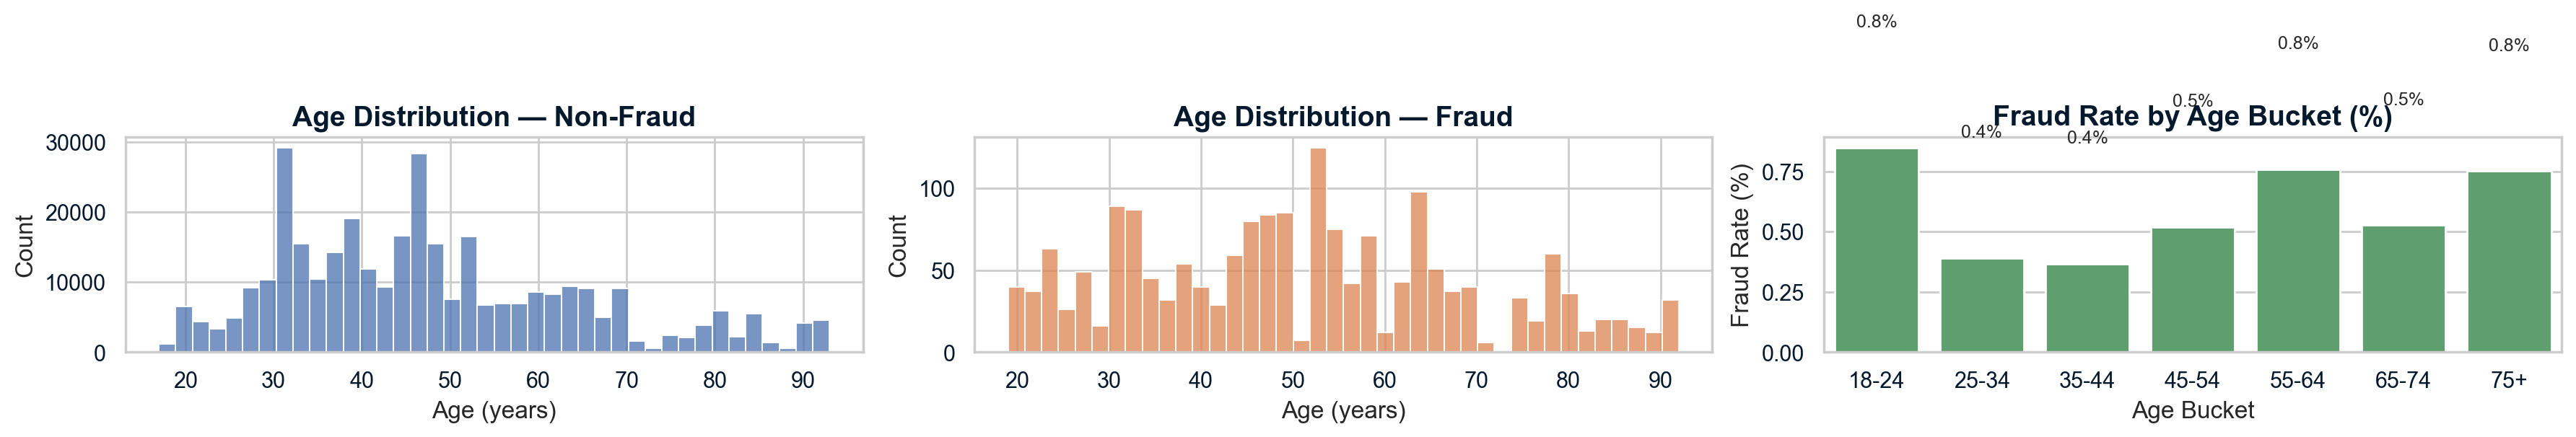

In [99]:
sns.set_theme(style="whitegrid", palette="muted")

# Prepare data
nonfraud_age = df.loc[df["is_fraud"] == 0, "age_years"].dropna()
fraud_age = df.loc[df["is_fraud"] == 1, "age_years"].dropna()

age_bins = [18, 25, 35, 45, 55, 65, 75, 100]
age_labels = ["18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75+"]
df["age_bucket"] = pd.cut(
    df["age_years"], bins=age_bins, labels=age_labels,
    right=True, include_lowest=True
)
age_stats = (
    df.groupby("age_bucket")["is_fraud"]
      .mean()
      .mul(100)
      .reindex(age_labels)
      .reset_index(name="fraud_rate")
)

# Create grid
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# --- Non-Fraud Age Distribution (Blue) ---
sns.histplot(
    nonfraud_age, bins=40,
    color="#4C72B0", edgecolor=None, ax=axes[0]
)
axes[0].set_title("Age Distribution — Non-Fraud", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Age (years)")
axes[0].set_ylabel("Count")

# --- Fraud Age Distribution (Orange) ---
sns.histplot(
    fraud_age, bins=40,
    color="#DD8452", edgecolor=None, ax=axes[1]
)
axes[1].set_title("Age Distribution — Fraud", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Age (years)")
axes[1].set_ylabel("Count")

# --- Fraud Rate by Age Bucket (Green) ---
sns.barplot(
    data=age_stats, x="age_bucket", y="fraud_rate",
    color="#55A868", ax=axes[2]
)
axes[2].set_title("Fraud Rate by Age Bucket (%)", fontsize=14, fontweight="bold")
axes[2].set_xlabel("Age Bucket")
axes[2].set_ylabel("Fraud Rate (%)")

# Value labels on Fraud Rate plot
for i, v in enumerate(age_stats["fraud_rate"]):
    axes[2].text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


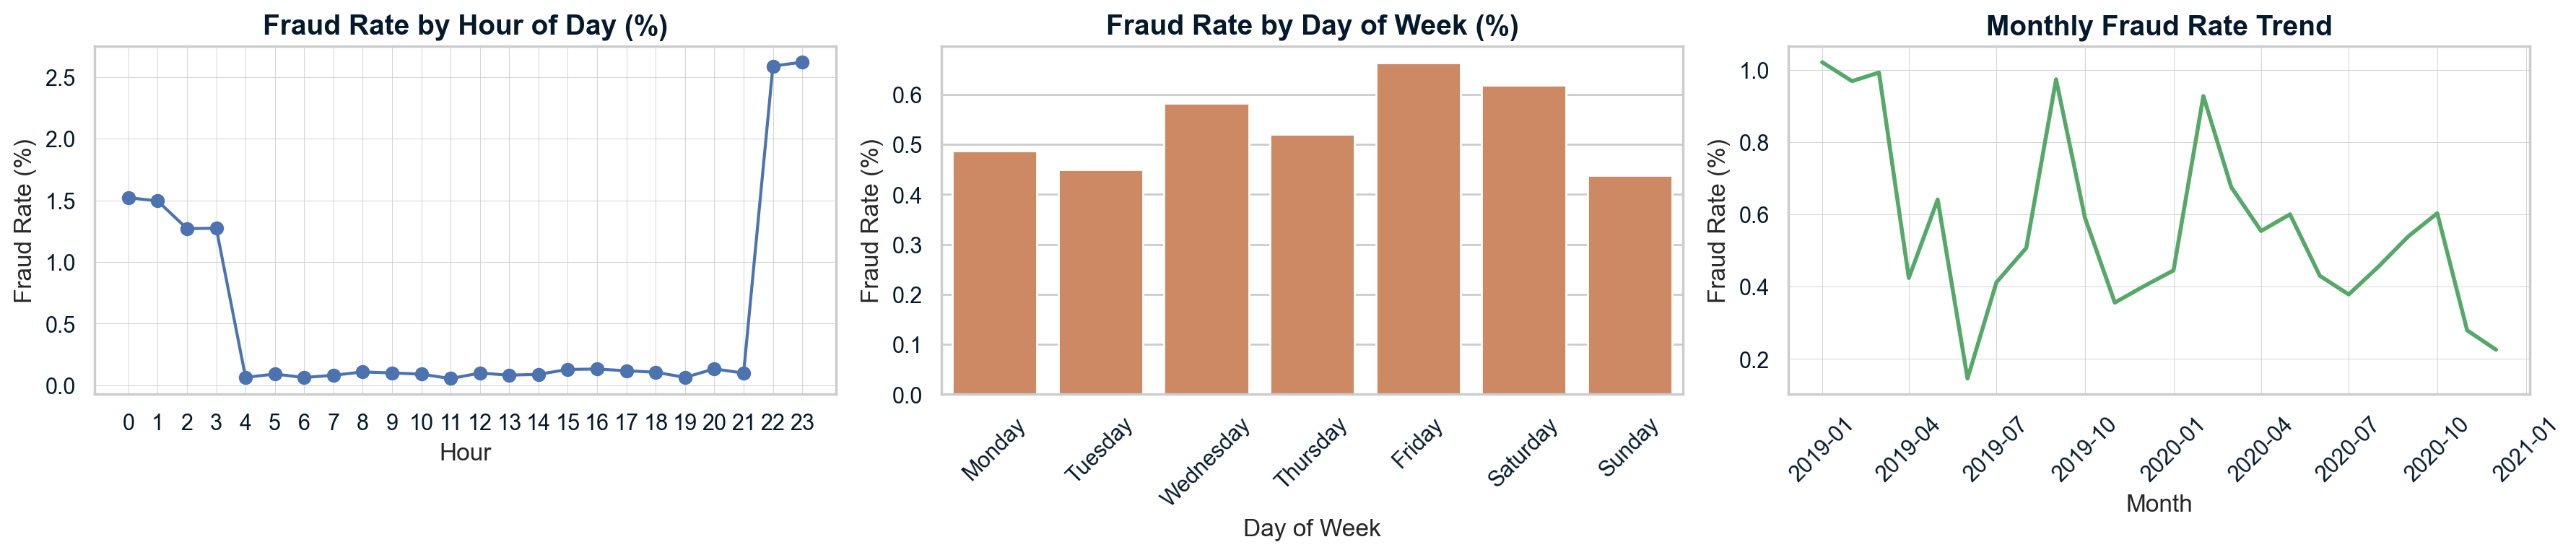

In [100]:
sns.set_theme(style="whitegrid", palette="muted")

# ---------- Data prep ----------
# Hourly fraud rate
hour_counts = df.groupby("trans_hour")["is_fraud"].agg(["count", "mean"])
hour_counts["fraud_rate_pct"] = hour_counts["mean"] * 100

# Day of week fraud rate
dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_counts = (
    df.groupby("trans_dow")["is_fraud"]
      .agg(["count", "mean"])
      .reindex(dow_order)
)
dow_counts["fraud_rate_pct"] = dow_counts["mean"] * 100

# Monthly fraud rate trend
df["date"] = pd.to_datetime(df["trans_date_trans_time"])
fraud_trend = df.groupby(df["date"].dt.to_period("M"))["is_fraud"].mean() * 100
fraud_trend.index = fraud_trend.index.to_timestamp()

# ---------- Create grid ----------
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot 1: Fraud Rate by Hour of Day (Blue)
axes[0].plot(hour_counts.index, hour_counts["fraud_rate_pct"], marker="o", color="#4C72B0")
axes[0].set_title("Fraud Rate by Hour of Day (%)", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("Fraud Rate (%)")
axes[0].set_xticks(range(0, 24, 1))
axes[0].grid(True, linewidth=0.3)

# Plot 2: Fraud Rate by Day of Week (Orange)
sns.barplot(
    x=dow_counts.index, y=dow_counts["fraud_rate_pct"],
    color="#DD8452", ax=axes[1]
)
axes[1].set_title("Fraud Rate by Day of Week (%)", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Day of Week")
axes[1].set_ylabel("Fraud Rate (%)")
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Monthly Fraud Rate Trend (Green)
axes[2].plot(fraud_trend.index, fraud_trend.values, color="#55A868", linewidth=2)
axes[2].set_title("Monthly Fraud Rate Trend", fontsize=14, fontweight="bold")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("Fraud Rate (%)")
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, linewidth=0.3)

plt.tight_layout()
plt.show()


# **Feature Engineering**

In [101]:
# 1. Amount Bucket
amt_bins = [0, 10, 25, 50, 100, 250, 500, 1000, 2500, 10000, np.inf]
amt_labels = ["0-10","10-25","25-50","50-100","100-250","250-500","500-1k","1k-2.5k","2.5k-10k","10k+"]
df["amt_bucket"] = pd.cut(df["amt"], bins=amt_bins, labels=amt_labels, right=False, include_lowest=True)



In [102]:
# 2. High-Risk Category Flag
# (Based on EDA results: shopping_net, grocery_pos, misc_net)
high_risk_categories = ["shopping_net", "grocery_pos", "misc_net"]
df["is_high_risk_category"] = df["category"].isin(high_risk_categories).astype(int)



In [103]:
# 3. Age and Age Bucket
#df["age_years"] = (df["trans_date_trans_time"] - df["dob"]).dt.days / 365.25
df.loc[(df["age_years"] < 18) | (df["age_years"] > 100), "age_years"] = np.nan  # clean unrealistic ages
age_bins = [18,25,35,45,55,65,75,100]
age_labels = ["18-24","25-34","35-44","45-54","55-64","65-74","75+"]
df["age_bucket"] = pd.cut(df["age_years"], bins=age_bins, labels=age_labels, right=True, include_lowest=True)


In [104]:
# 4. Time Features
df["trans_hour"] = df["trans_date_trans_time"].dt.hour
df["trans_dow"] = df["trans_date_trans_time"].dt.day_name()
df["is_night"] = df["trans_hour"].apply(lambda x: 1 if (x >= 22 or x <= 4) else 0)



In [105]:
# 5. Geographic Risk (State-level fraud rate mapping)
state_fraud_rate = df.groupby("state")["is_fraud"].mean()
df["state_fraud_rate"] = df["state"].map(state_fraud_rate)

In [106]:
# 6. Merchant Distance from Customer
# Using Haversine formula
R = 6371  # Earth radius in km
lat1 = np.radians(df["lat"])
lon1 = np.radians(df["long"])
lat2 = np.radians(df["merch_lat"])
lon2 = np.radians(df["merch_long"])

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
c = 2 * np.arcsin(np.sqrt(a))
df["merchant_distance_km"] = R * c

In [107]:
df.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,amt_bucket,age_years,trans_hour,trans_dow,age_bucket,date,is_high_risk_category,is_night,state_fraud_rate,merchant_distance_km
0,2019-01-01 00:00:44,"Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,100-250,41.0,0,Tuesday,35-44,2019-01-01 00:00:44,1,1,0.004660,30.212176
1,2019-01-01 00:00:51,Lind-Buckridge,entertainment,220.11,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,100-250,57.0,0,Tuesday,55-64,2019-01-01 00:00:51,0,1,0.004107,108.206083
2,2019-01-01 00:07:27,Kiehn Inc,grocery_pos,96.29,Grenada,CA,41.6125,-122.5258,589,Systems analyst,1945-12-21,413636e759663f264aae1819a4d4f231,41.657520,-122.230347,0,50-100,73.0,0,Tuesday,65-74,2019-01-01 00:07:27,1,1,0.004994,25.059079
3,2019-01-01 00:09:03,Beier-Hyatt,shopping_pos,7.77,High Rolls Mountain Park,NM,32.9396,-105.8189,899,Naval architect,1967-08-30,8a6293af5ed278dea14448ded2685fea,32.863258,-106.520205,0,0-10,51.0,0,Tuesday,45-54,2019-01-01 00:09:03,0,1,0.005165,66.021685
4,2019-01-01 00:21:32,Bruen-Yost,misc_pos,6.85,Freedom,WY,43.0172,-111.0292,471,"Education officer, museum",1967-08-02,f3c43d336e92a44fc2fb67058d5949e3,43.753735,-111.454923,0,0-10,51.0,0,Tuesday,45-54,2019-01-01 00:21:32,0,1,0.004284,88.830984


# **Modeling**

# Model Data Preparation and Split

In [108]:
# Select features & target
features = [
    "amt", "amt_bucket", "is_high_risk_category", "age_years", "age_bucket",
    "trans_hour", "trans_dow", "is_night", "state_fraud_rate", "merchant_distance_km"
]
target = "is_fraud"

X = df[features].copy()
y = df[target]

In [109]:
# One-hot encode categoricals
X = pd.get_dummies(X, columns=["amt_bucket", "age_bucket", "trans_dow"], drop_first=True)

# Fill missing values
X = X.fillna(0)

In [110]:
# Scale numeric features
numeric_cols = ["amt", "age_years", "trans_hour", "state_fraud_rate", "merchant_distance_km"]
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [111]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Fraud rate in train: {y_train.mean()*100:.3f}%, Fraud rate in test: {y_test.mean()*100:.3f}%")

Train shape: (271685, 28), Test shape: (67922, 28)
Fraud rate in train: 0.525%, Fraud rate in test: 0.524%


# Modeling and Comparison

In [112]:
# Train Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]



In [113]:
# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200, 
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [114]:
# Train XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

In [115]:
# Compare Models
def evaluate_model(name, y_true, y_pred, y_prob):
    recall = np.round(classification_report(y_true, y_pred, output_dict=True)['1']['recall'], 4)
    precision = np.round(classification_report(y_true, y_pred, output_dict=True)['1']['precision'], 4)
    f1 = np.round(classification_report(y_true, y_pred, output_dict=True)['1']['f1-score'], 4)
    roc_auc = np.round(roc_auc_score(y_true, y_prob), 4)
    pr_auc = np.round(average_precision_score(y_true, y_prob), 4)
    return [name, recall, precision, f1, roc_auc, pr_auc]

results = []
results.append(evaluate_model("Logistic Regression", y_test, y_pred_lr, y_prob_lr))
results.append(evaluate_model("Random Forest", y_test, y_pred_rf, y_prob_rf))
results.append(evaluate_model("XGBoost", y_test, y_pred_xgb, y_prob_xgb))

results_df = pd.DataFrame(results, columns=["Model", "Recall", "Precision", "F1-score", "ROC-AUC", "PR-AUC"])
print("\n=== Model Comparison ===")
print(results_df)


=== Model Comparison ===
                 Model  Recall  Precision  F1-score  ROC-AUC  PR-AUC
0  Logistic Regression  0.8904     0.0534    0.1008   0.9638  0.2455
1        Random Forest  0.4831     0.8821    0.6243   0.9542  0.6838
2              XGBoost  0.8034     0.2624    0.3956   0.9827  0.7030


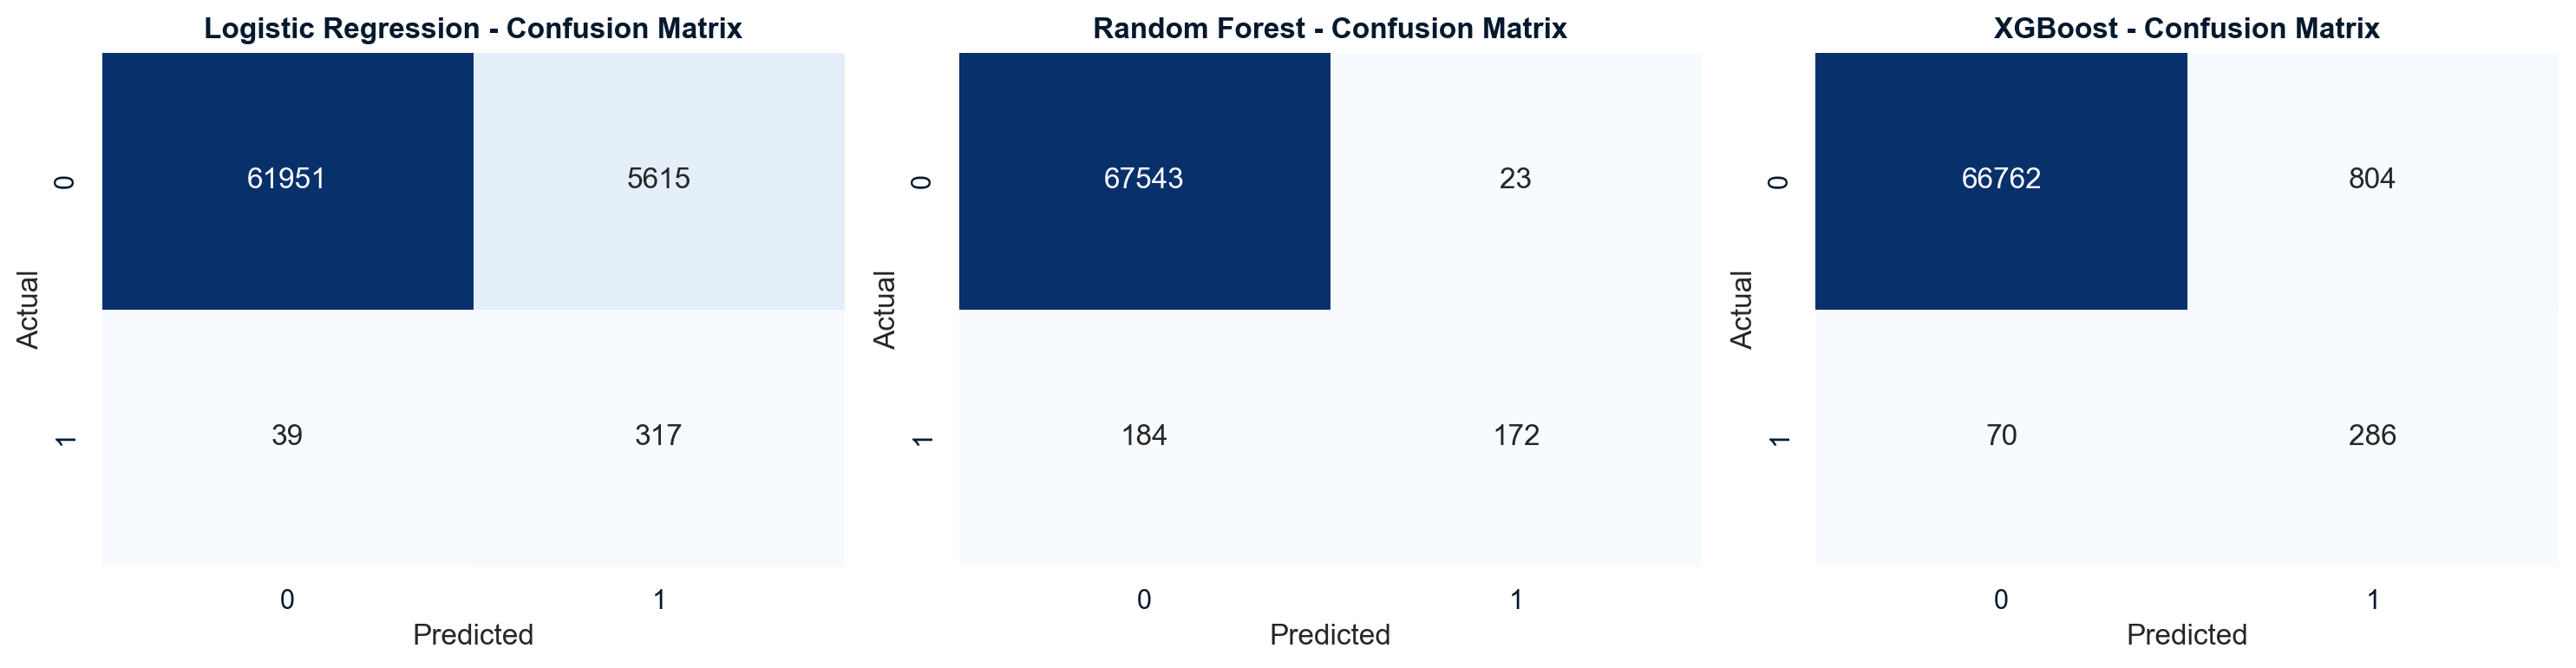

In [116]:
# Confusion Matrix
models_preds = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

sns.set_theme(style="whitegrid")

# Prepare figure with 1 row and N columns
n_models = len(models_preds)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))  # width scales with number of models

if n_models == 1:
    axes = [axes]  # ensure iterable even if only one model

# Loop through models and plot each confusion matrix
for ax, (name, preds) in zip(axes, models_preds.items()):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax
    )
    ax.set_title(f"{name} - Confusion Matrix", fontsize=12, fontweight="bold")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


# **Evaluation**

In [117]:
import shap

# Prepare SHAP explainer
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

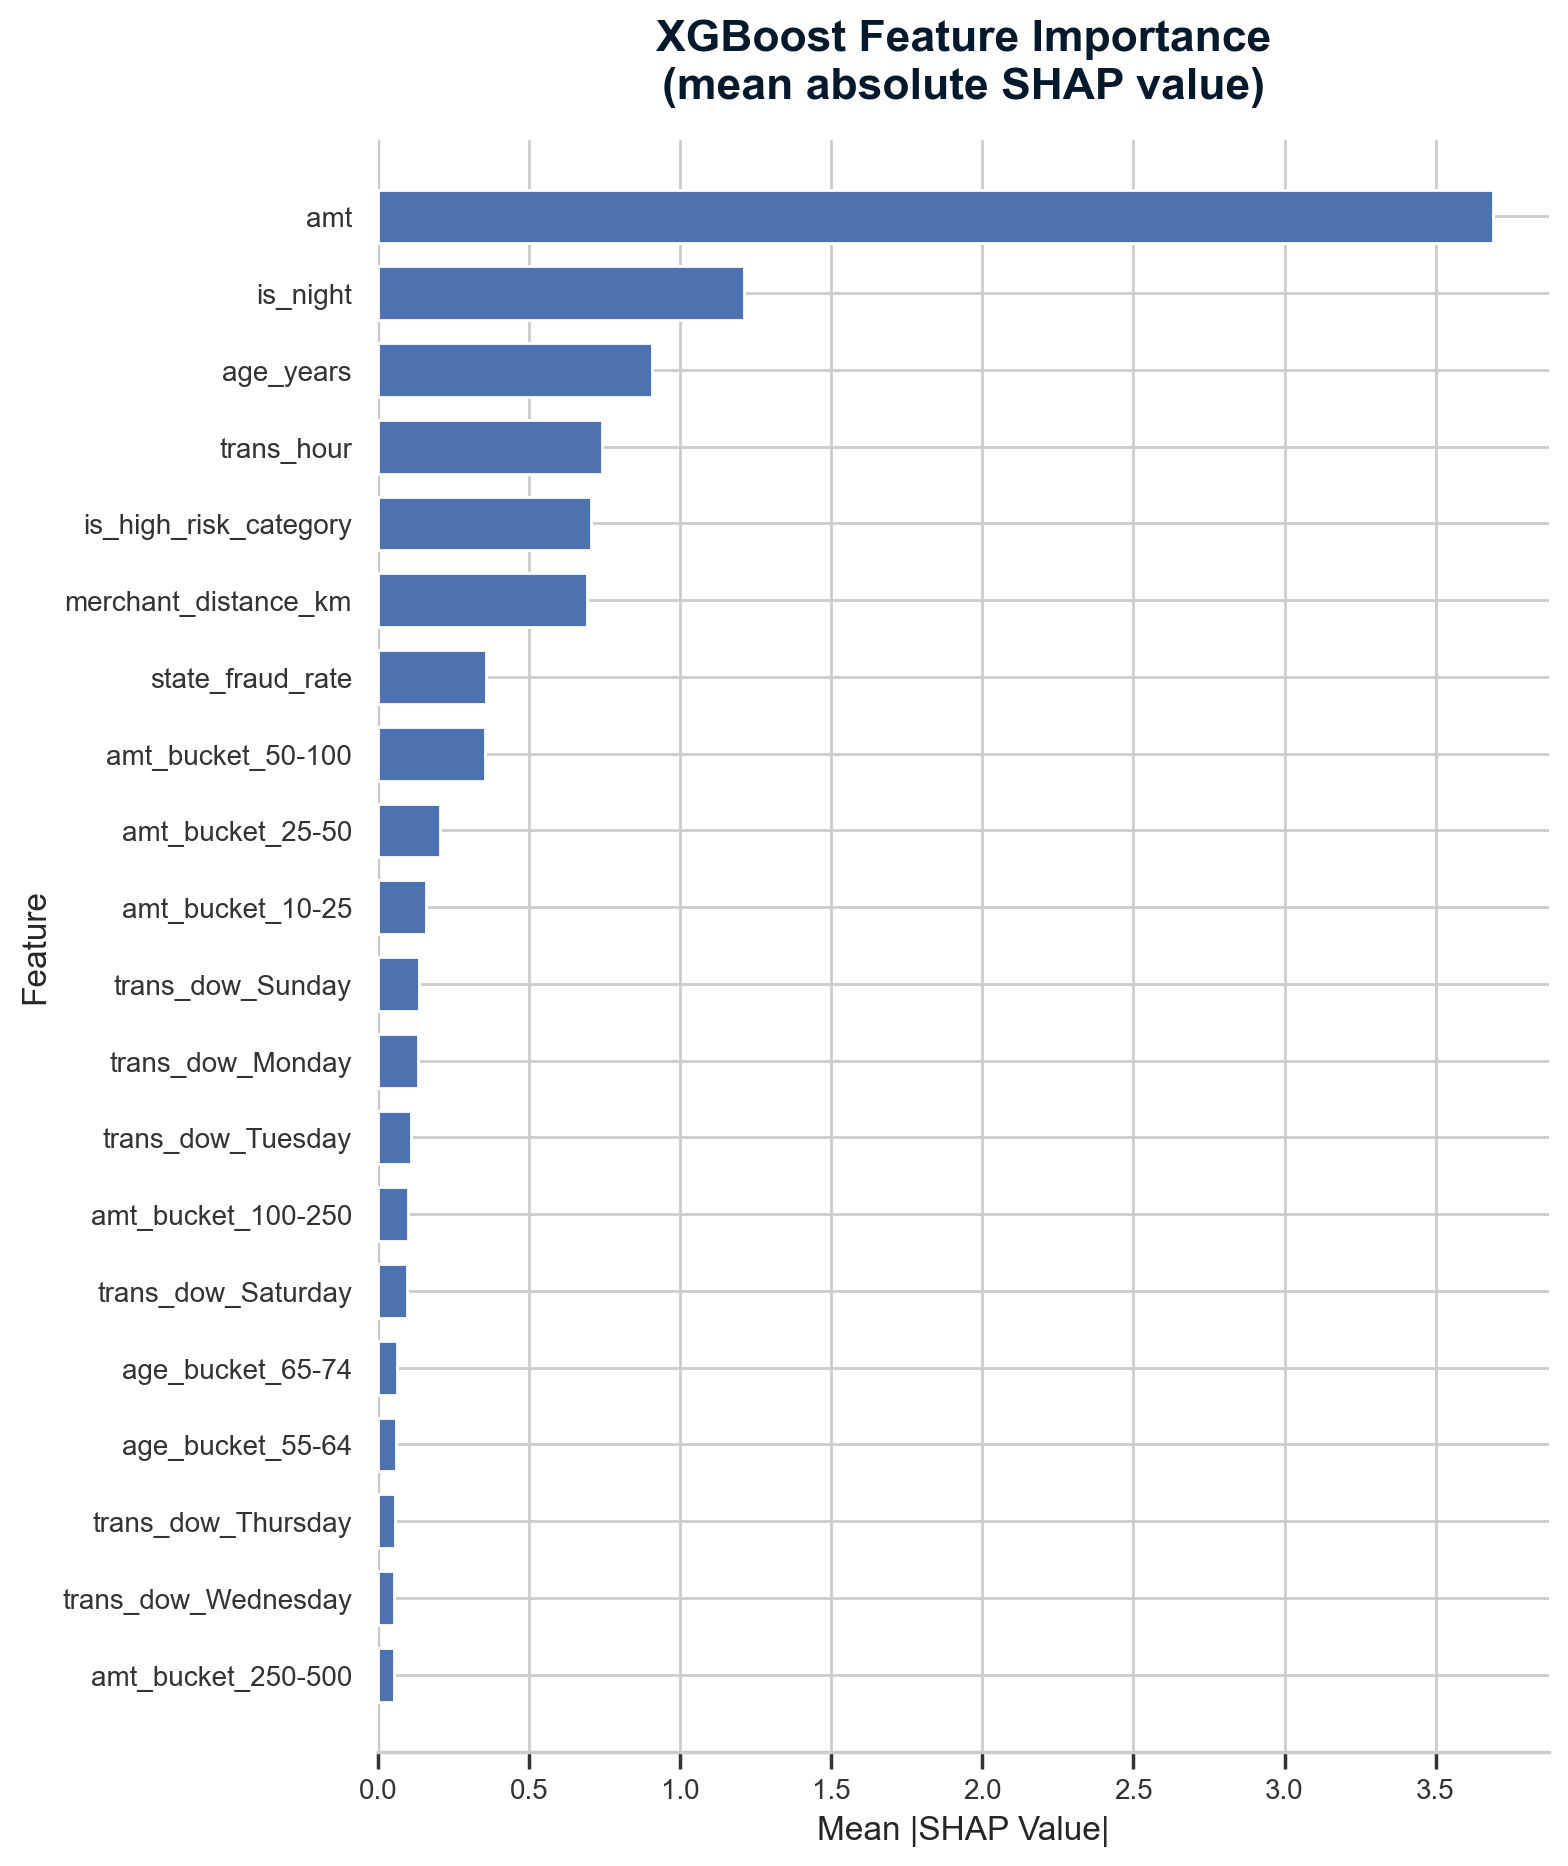

In [118]:
# ------------Global Feature Importance---------------

# Increase default figure size
plt.figure(figsize=(8, 6))

# Title
plt.title(
    "XGBoost Feature Importance\n(mean absolute SHAP value)",
    fontsize=16, fontweight="bold", pad=15
)

# SHAP summary plot (bar)
shap.summary_plot(
    shap_values, X_test,
    plot_type="bar",
    color="#4C72B0",  # Blue from theme
    show=False
)

# Beautify axes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Mean |SHAP Value|", fontsize=12)
plt.ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.show()


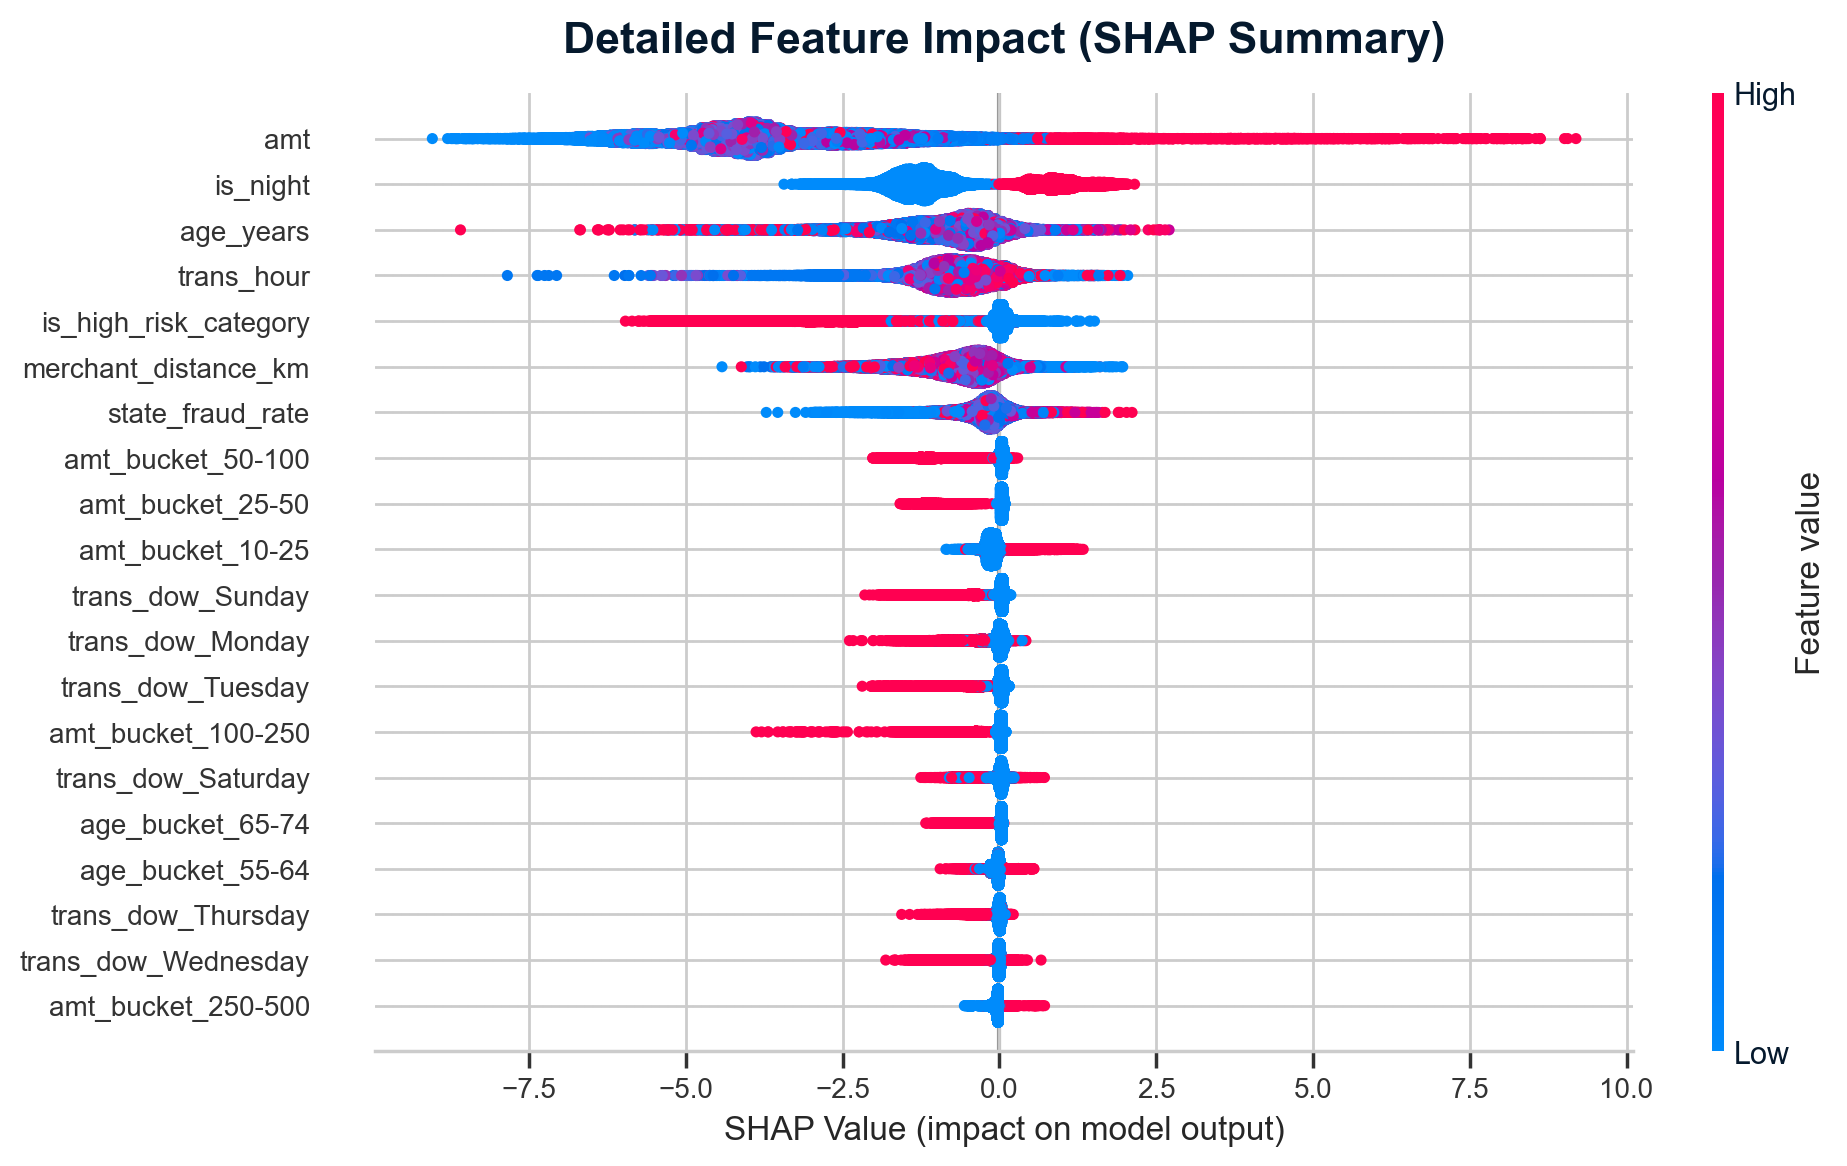

In [119]:
# -----------Detailed Feature Impact (summary plot)------------

# Set larger default plot size
plt.figure(figsize=(10, 6))

# Add title above the SHAP plot
plt.title(
    "Detailed Feature Impact (SHAP Summary)",
    fontsize=16, fontweight="bold", pad=15
)

# SHAP summary plot (dot plot)
shap.summary_plot(
    shap_values, X_test,
    show=False,  # Prevent auto-show so we can format
    plot_size=(10, 6)
)

# Beautify axes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("SHAP Value (impact on model output)", fontsize=12)

plt.tight_layout()
plt.show()

